In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Basic Imports
import warnings
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm

2025-11-25 12:12:45.252537: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764072765.425050      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764072765.474509      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [3]:
# NLP imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical

In [4]:
# Model creation imports
from tensorflow.keras.models import Sequential, Model

In [5]:
# Computer Vision imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import DenseNet201

In [6]:
# Warnings and Visualisation Imports
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size']= 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [7]:
# Model learnings & Losses Imports
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Image Captioning
## What is Image Captioning ?

## Image Captioning is the process of generating textual description of an image. It uses both Natural Language Processing and Computer Vision to generate the captions.
This task lies at the intersection of computer vision and natural language processing. Most image captioning systems use an encoder-decoder framework, where an input image is encoded into an intermediate representation of the information in the image, and then decoded into a descriptive text sequence.
## CNNs + RNNs (LSTMs)

To perform Image Captioning we will require two deep learning models combined into one for the training purpose
CNNs extract the features from the image of some vector size aka the vector embeddings. The size of these embeddings depend on the type of pretrained network being used for the feature extraction
LSTMs are used for the text generation process. The image embeddings are concatenated with the word embeddings and passed to the LSTM to generate the next word
For a more illustrative explanation of this architecture check the Modelling section for a picture representation

In [8]:
image_path= '/kaggle/input/flickr8k/Images'
data = pd.read_csv("/kaggle/input/flickr8k/captions.txt")
data.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

# Visualisation

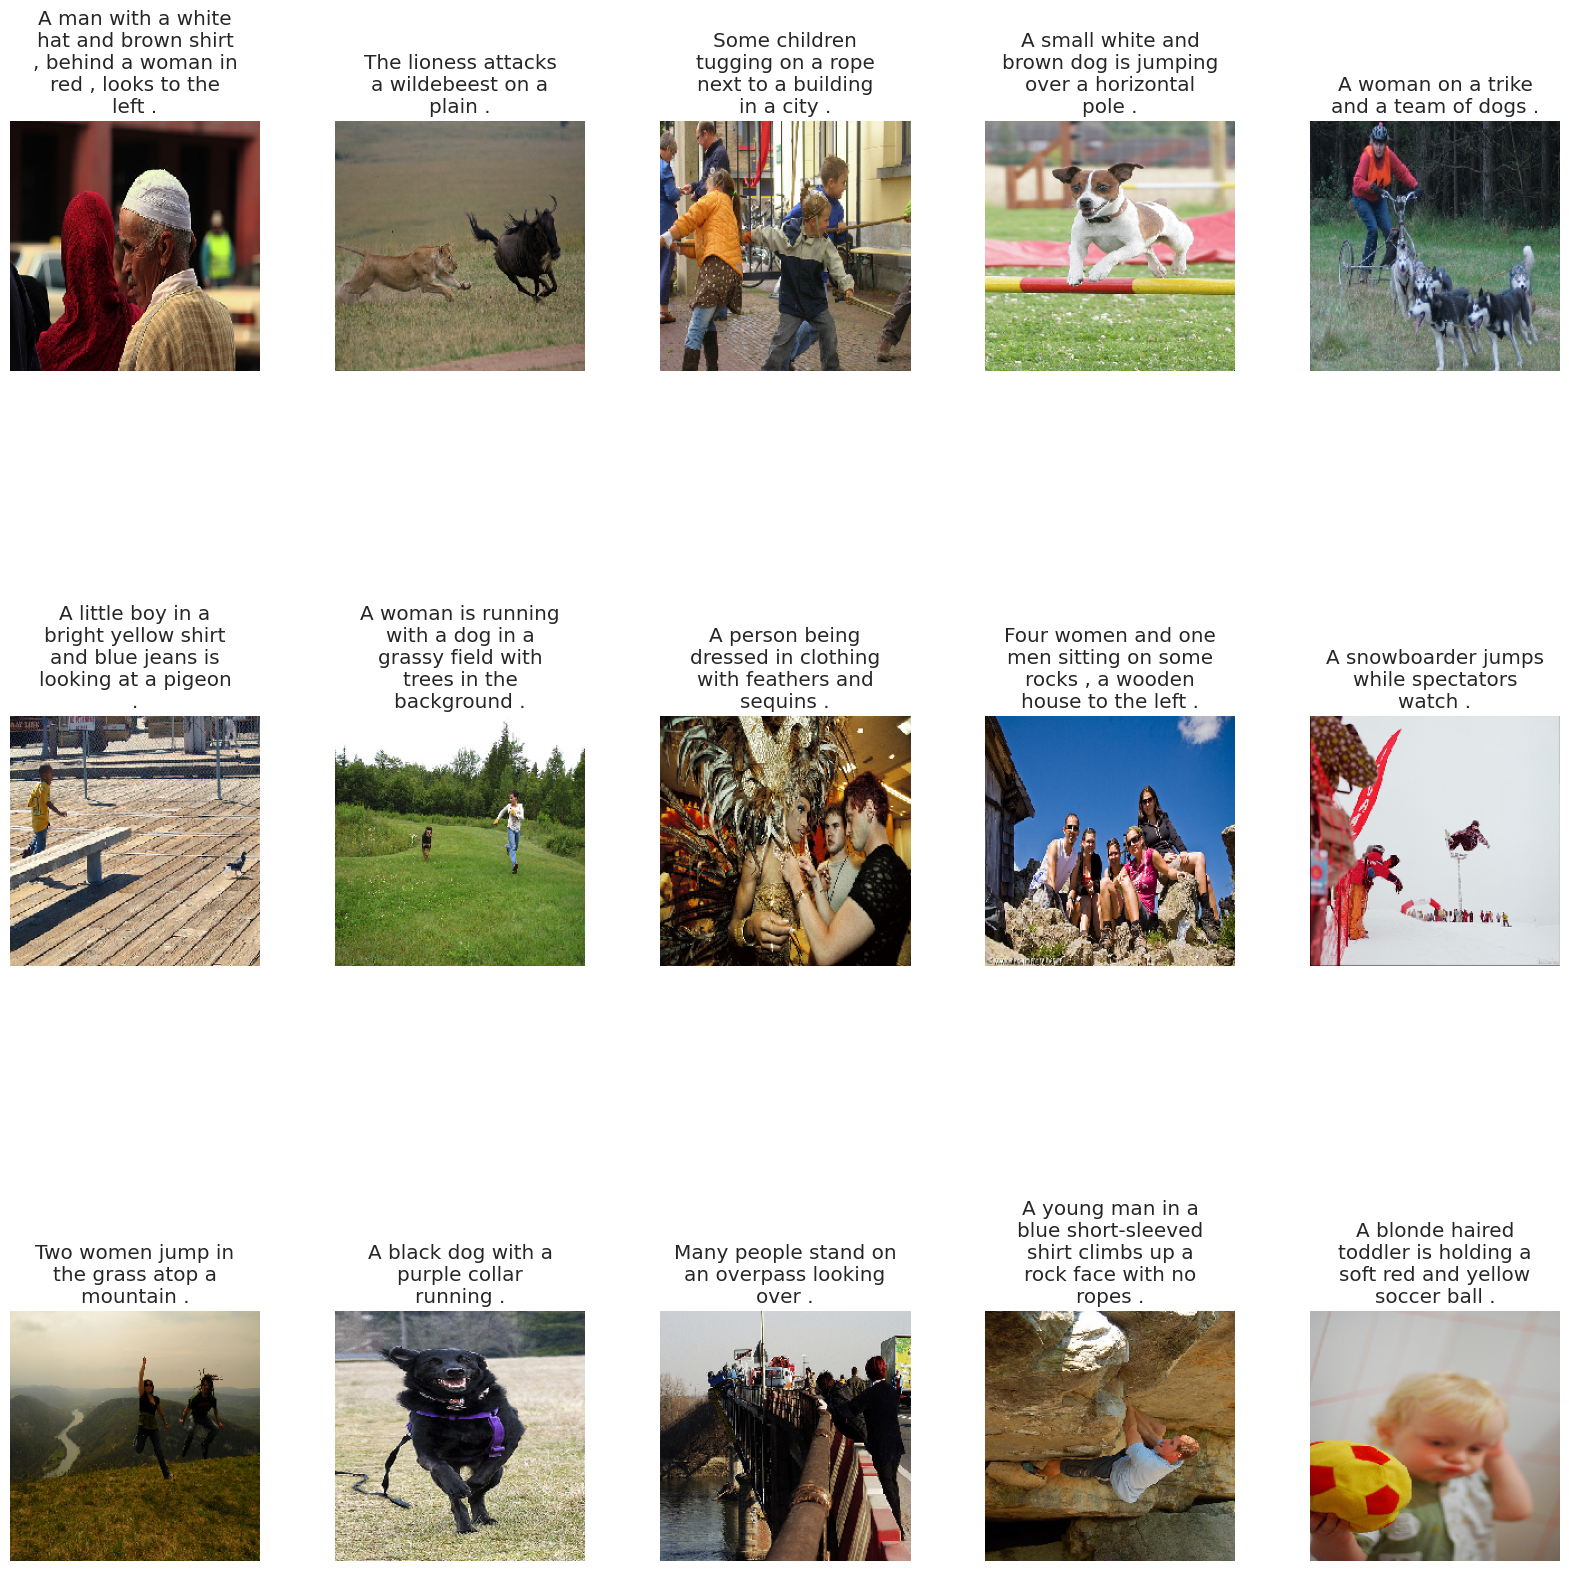

In [9]:
def read_image(path,img_size=224):
    img= load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img=img_to_array(img)
    img= img/255
    return img
def display_image(temp_df):
    temp_df=temp_df.reset_index(drop=True)
    plt.figure(figsize=(20,20))
    n=0
    for i in range(15):
        n+=1
        plt.subplot(3,5,n);
        plt.subplots_adjust(hspace=0.7,wspace=0.3)
        image = read_image(f"../input/flickr8k/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")
display_image(data.sample(15))

# Caption Text Preprocessing Steps
## Convert sentences into lowercase
1. Remove special characters and numbers present in the text
2. Remove single characters
3. Add a starting and an ending tag to the sentences to indicate the beginning and the ending of a sentence

In [10]:
import re
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].str.replace(r"\s+", " ", regex=True)
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

# Preprocessed Text

In [11]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

# Tokenization and Encoded Representation
## The words in a sentence are separated/tokenized and encoded in a one hot representation
## These encodings are then passed to the embeddings layer to generate word embeddings


In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

In [13]:
tokenizer.texts_to_sequences([captions[3]])

[[1, 39, 18, 118, 4, 393, 19, 59, 2428, 2]]

In [14]:
images= data['image'].unique().tolist()
nimages= len(images)

split_index= round(0.8*nimages)

train_images = images[:split_index]
val_images= images[split_index:]

split_index

6473

In [15]:
train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

In [16]:
train

image  \
0      1000268201_693b08cb0e.jpg   
1      1000268201_693b08cb0e.jpg   
2      1000268201_693b08cb0e.jpg   
3      1000268201_693b08cb0e.jpg   
4      1000268201_693b08cb0e.jpg   
...                          ...   
32360  3601569729_bf4bf82768.jpg   
32361  3601569729_bf4bf82768.jpg   
32362  3601569729_bf4bf82768.jpg   
32363  3601569729_bf4bf82768.jpg   
32364  3601569729_bf4bf82768.jpg   

                                                 caption  
0      startseq child in pink dress is climbing up se...  
1        startseq girl going into wooden building endseq  
2      startseq little girl climbing into wooden play...  
3      startseq little girl climbing the stairs to he...  
4      startseq little girl in pink dress going into ...  
...                                                  ...  
32360  startseq group of race horses run down track c...  
32361                         startseq horse race endseq  
32362      startseq jockeys on horses during race endseq  
32363  startseq the horses race on the dirt track whi...  
32364  startseq there are riders and horses in horse ...  

[32365 rows x 2 columns]

# Image Feature Extraction
1. DenseNet 201 Architecture is used to extract the features from the images
2. Any other pretrained architecture can also be used for extracting features from these images
3. Since the Global Average Pooling layer is selected as the final layer of the DenseNet201 model for our feature extraction, our image embeddings will be a vector of size 1920

In [17]:
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Flatten,Input,Dropout,concatenate,Reshape,Embedding, LSTM, concatenate,add

In [18]:
conv_base = keras.applications.DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3),
    pooling='avg'               # <-- FIXED
)

conv_base.trainable = False     # optional but recommended

model = Sequential([
    conv_base,
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])


I0000 00:00:1764072783.786974      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [19]:
image_path

'/kaggle/input/flickr8k/Images'

In [20]:
data.head()['image']

0    1000268201_693b08cb0e.jpg
1    1000268201_693b08cb0e.jpg
2    1000268201_693b08cb0e.jpg
3    1000268201_693b08cb0e.jpg
4    1000268201_693b08cb0e.jpg
Name: image, dtype: object

In [21]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

82524592/82524592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


  0%|          | 0/8091 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1764072796.714674     113 service.cc:148] XLA service 0x7a7b740030c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764072796.715337     113 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1764072798.766650     113 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1764072810.957549     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 8091/8091 [12:43<00:00, 10.60it/s]


In [22]:
features['1000268201_693b08cb0e.jpg'][0].shape

(1920,)

In [23]:
class CustomDataGenerator(Sequence):
    def __init__(self,df,X_col,y_col,batch_size,directory,tokenizer,vocab_size,max_length,features,shuffle=True):
        self.df=df.copy()
        self.X_col=X_col
        self.y_col=y_col
        self.directory=directory
        self.batch_size= batch_size
        self.tokenizer=tokenizer
        self.vocab_size=vocab_size
        self.max_length=max_length
        self.features=features
        self.shuffle=shuffle
        self.n=len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df=self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch= self.df.loc[index*self.batch_size:(index+1)*self.batch_size,:]
        X1,X2,y= self.__get_data(batch)
        return (X1,X2),y
    
    def __get_data(self,batch):
    
        X1,X2,y= list(),list(),list()
        images= batch[self.X_col].tolist()
    
        for image in images:
            feature = self.features[image][0]
            captions= batch.loc[batch[self.X_col]==image,self.y_col].tolist()
#            print(captions)
            for caption in captions:
                seq= self.tokenizer.texts_to_sequences([caption])[0]
        
                for i in range(1,len(seq)):
                    in_seq,out_seq=seq[:i],seq[i]
                    in_seq= pad_sequences([in_seq],maxlen=self.max_length)[0]
                    out_seq= to_categorical([out_seq],num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
        # Debug: print one sample shape and len
        # print("len:", len(X1), len(X2), len(y))
        # print("X1[0].shape:", np.array(X1[0]).shape)
        # print("X2[0].shape:", np.array(X2[0]).shape)
        # print("y[0].shape :", np.array(y[0]).shape)
    
        # Try to build arrays one by one
        X1_arr = np.array(X1)
        X2_arr = np.array(X2)
        y_arr  = np.array(y)
    
        # print("X1_arr.shape:", X1_arr.shape)
        # print("X2_arr.shape:", X2_arr.shape)
        # print("y_arr.shape :", y_arr.shape)            
        return np.array(X1), np.array(X2), np.array(y)


train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)     

In [24]:
train_generator[1]

((array([[1.9476042e-04, 7.0213038e-04, 1.4947486e-03, ..., 2.7233858e-02,
          5.5759555e-01, 3.8916537e-01],
         [1.9476042e-04, 7.0213038e-04, 1.4947486e-03, ..., 2.7233858e-02,
          5.5759555e-01, 3.8916537e-01],
         [1.9476042e-04, 7.0213038e-04, 1.4947486e-03, ..., 2.7233858e-02,
          5.5759555e-01, 3.8916537e-01],
         ...,
         [7.6072298e-05, 6.1783084e-04, 1.9857232e-03, ..., 5.4502711e-02,
          1.0848639e+00, 2.5176878e+00],
         [7.6072298e-05, 6.1783084e-04, 1.9857232e-03, ..., 5.4502711e-02,
          1.0848639e+00, 2.5176878e+00],
         [7.6072298e-05, 6.1783084e-04, 1.9857232e-03, ..., 5.4502711e-02,
          1.0848639e+00, 2.5176878e+00]], dtype=float32),
  array([[   0,    0,    0, ...,    0,    0,    1],
         [   0,    0,    0, ...,    0,    1,  184],
         [   0,    0,    0, ...,    1,  184, 1054],
         ...,
         [   0,    0,    0, ...,  127,    3,   28],
         [   0,    0,    0, ...,    3,   28,  438],

# Modelling
1. The image embedding representations are concatenated with the first word of sentence ie. starseq and passed to the LSTM network
2. The LSTM network starts generating words after each input thus forming a sentence at the end

In [25]:
from tensorflow.keras.utils import plot_model

input1= Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features= Dense(256,activation='relu')(input1)
img_features_reshaped= Reshape((1,256),input_shape=(256,))(img_features)

sentence_features=Embedding(vocab_size,256,mask_zero=False)(input2)
merged= concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features=LSTM(256)(merged)
x=Dropout(0.5)(sentence_features)
x=add([x,img_features])
x= Dense(128,activation='relu')(x)
x=Dropout(0.5)(x)
output= Dense(vocab_size,activation='softmax')(x)

caption_model= Model(inputs=[input1,input2],outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')


In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


# Define the model checkpoint
model_name= "model.keras"
checkpoint= ModelCheckpoint(
    model_name,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

earlystopping= EarlyStopping(monitor='val_loss',min_delta=0,patience=5,verbose=1,restore_best_weights=True)
learning_rate_reduction= ReduceLROnPlateau(monitor='val_loss',
                                          patience=3,
                                          factor=0.2,
                                          min_lr=0.0000001)

history= caption_model.fit(train_generator,epochs=50,
                          validation_data=validation_generator,
                          callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 5.7436
Epoch 1: val_loss improved from inf to 4.34407, saving model to model.keras
505/505 ━━━━━━━━━━━━━━━━━━━━ 84s 160ms/step - loss: 5.7424 - val_loss: 4.3441 - learning_rate: 0.0010
Epoch 2/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 4.3551
Epoch 2: val_loss improved from 4.34407 to 4.03086, saving model to model.keras
505/505 ━━━━━━━━━━━━━━━━━━━━ 76s 151ms/step - loss: 4.3549 - val_loss: 4.0309 - learning_rate: 0.0010
Epoch 3/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 4.0445
Epoch 3: val_loss improved from 4.03086 to 3.88248, saving model to model.keras
505/505 ━━━━━━━━━━━━━━━━━━━━ 80s 158ms/step - loss: 4.0444 - val_loss: 3.8825 - learning_rate: 0.0010
Epoch 4/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 3.8636
Epoch 4: val_loss improved from 3.88248 to 3.79221, saving model to model.keras
505/505 ━━━━━━━━━━━━━━━━━━━━ 81s 160ms/step - loss: 3.8635 - val_loss: 3.7922 - learning_rate: 0.0010


# Learning Curve
## The model has clearly overfit, possibly due to less amount of data
1. We can tackle this problem in two ways
2. Train the model on a larger dataset Flickr40k
3. Attention Models

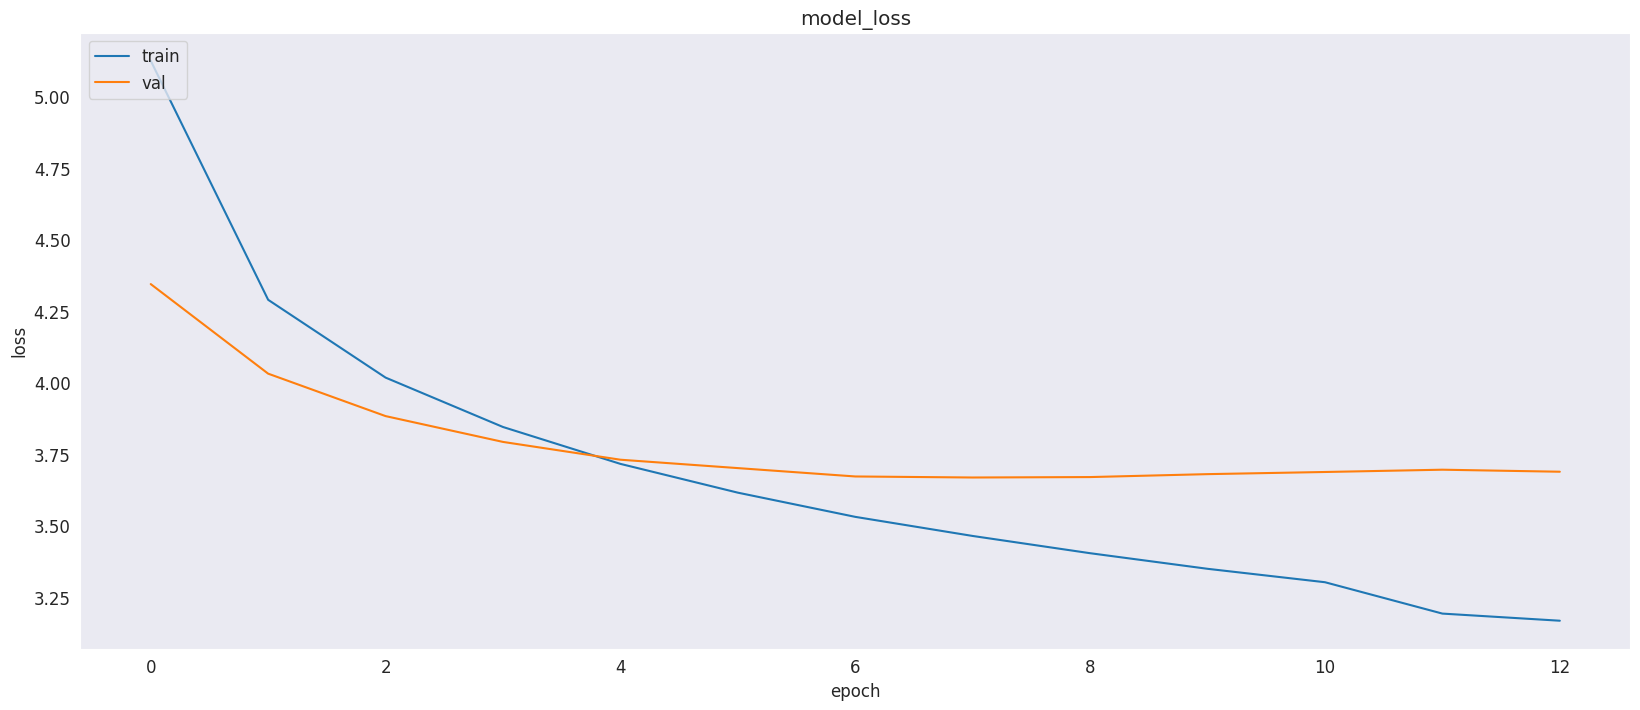

In [27]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')
plt.show()

# Caption Generation Utility Functions
* Utility functions to generate the captions of input images at the inference time.
* Here the image embeddings are passed along with the first word, followed by which *  the text embedding of each new word is passed to generate the next word

In [28]:
import pickle 

# save a tokenizer
with open("tokenizer.pkl","wb") as f:
    pickle.dump(tokenizer,f)

# save the feature extractor model
pickle.dump(fe,open('feature_extractor.pkl','wb'))

In [29]:
fe.save("feature_extractor.keras")

In [30]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

model_path="model.keras"
tokenizer_path="tokenizer.pkl"
feature_extractor_path="feature_extractor.keras"

def generate_and_display_caption(image_path,model_path,tokenizer_path,feature_extractor_path,max_length=34,img_size=224):

    caption_model=load_model(model_path)
    '''feature_extractor.predict(img) Passes the image through DenseNet:feature_extractor outputs shape (1, 1920)'''
    feature_extractor= load_model(feature_extractor_path)
    with open(tokenizer_path,"rb") as f:
        tokenizer= pickle.load(f)
    img = load_img(image_path,target_size=(img_size,img_size))
    img= img_to_array(img)/255.0
    img=np.expand_dims(img,axis=0)
    image_features= feature_extractor.predict(img,verbose=1)

    in_text="startseq"
    for i in range(max_length):
        sequence= tokenizer.texts_to_sequences([in_text])[0]
        sequence= pad_sequences([sequence],maxlen=max_length)
        yhat = caption_model.predict([image_features,sequence],verbose=0)
        yhat_index=np.argmax(yhat)
        word= tokenizer.index_word.get(yhat_index,None)
        if word is None:
            break
        in_text+=" "+word
        if word=="endseq":
            break
    caption = in_text.replace("startseq","").replace("endseq","").strip()
    # Display the image with the generated caption
    img = load_img(image_path, target_size=(img_size, img_size))
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption, fontsize=16, color='blue')
    plt.show()
    
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


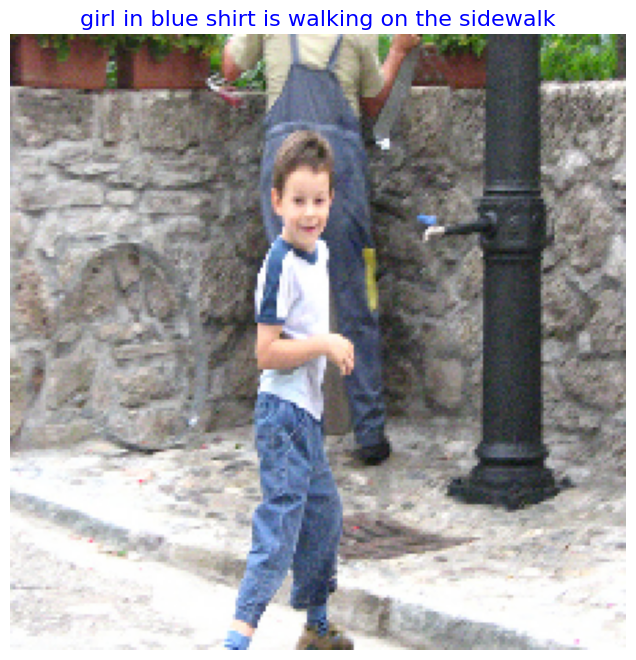

In [31]:
# Example_usage
image_path= "/kaggle/input/flickr8k/Images/1015118661_980735411b.jpg"
generate_and_display_caption(image_path,model_path,tokenizer_path, feature_extractor_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


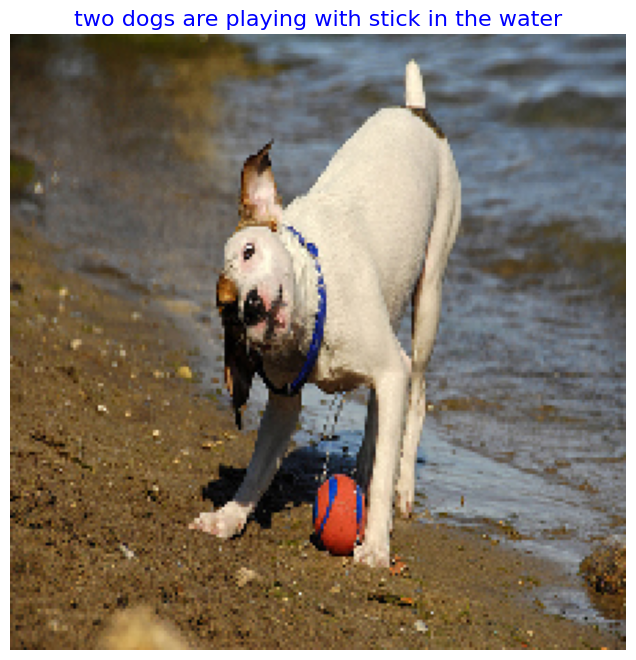

In [32]:
# Example_usage
image_path= "/kaggle/input/flickr8k/Images/1012212859_01547e3f17.jpg"
generate_and_display_caption(image_path,model_path,tokenizer_path, feature_extractor_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


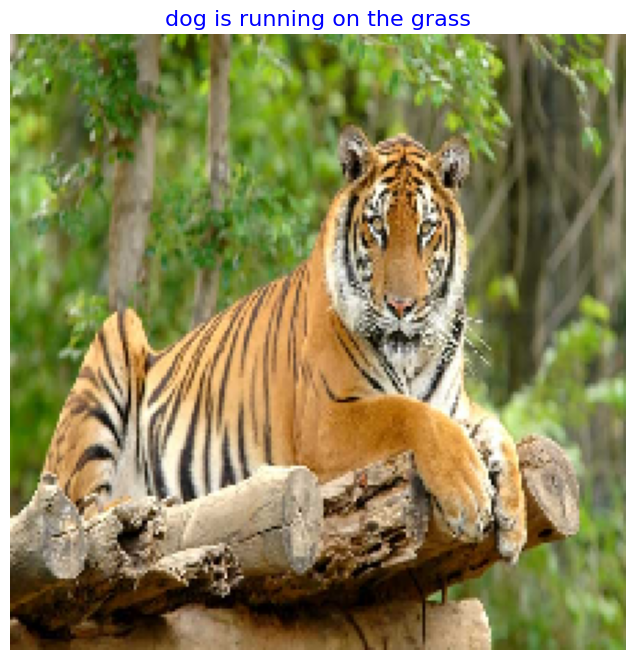

In [33]:
# Example_usage
image_path= "/kaggle/input/parrot-bengal/Bengal.jpg"
generate_and_display_caption(image_path,model_path,tokenizer_path, feature_extractor_path)